In [3]:
!nvidia-smi
!pip install torchinfo

Wed Jul 24 13:51:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# import

import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torchinfo
import os
from pytz import timezone
from tqdm import tqdm

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)  # 출력결과: cuda
print('Count of using GPUs:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())

Device: cuda
Count of using GPUs: 1
Current cuda device: 0


In [5]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
BATCH_SIZE = 64
EPOCHS = 20
IMG_SIZE = 32
NUM_CLASSES = 10

# 하이퍼파리미터-학습률 스케줄링 설정
def lr_schedule(epoch):
    if epoch <= 2:
        lr = 5e-4
    elif epoch <= 5:
        lr = 2e-4
    elif epoch <= 9:
        lr = 5e-5
    else:
        lr = 1e-5
    return lr

In [6]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            probabilities = F.softmax(model(images), dim=-1)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [7]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [8]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [9]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [10]:
# 전체 학습 루프
def training_loop(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):
    train_losses = []
    valid_losses = []
    print(
        datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
        "--- Start Training Loop ---",
    )

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        running_loss = 0.0
        valid_loader_tqdm = tqdm(valid_loader, desc=f"Validation {epoch + 1}/{epochs}", leave=False)
        with torch.no_grad():
            for inputs, labels in valid_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        valid_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch + 1}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [11]:
# LeNet5 모델 정의
class LeNet5(nn.Module):

    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.fc6 = nn.Linear(120, 84)
        self.fc7 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x)

        x = self.pool2(x)

        x = self.conv3(x)
        x = F.leaky_relu(x)

        x = self.pool4(x)

        x = self.conv5(x)
        x = F.leaky_relu(x)

        x = x.view(x.size(0), -1)
        x = self.fc6(x)
        x = F.leaky_relu(x)

        logits = self.fc7(x)

        return logits
torchinfo.summary(LeNet5(NUM_CLASSES), input_size=(1, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            156
├─AvgPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─AvgPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Linear: 1-6                            [1, 84]                   10,164
├─Linear: 1-7                            [1, 10]                   850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.30

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 897513.16it/s] 


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134579.81it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1272216.80it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11545775.01it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

train dataset size:  49000
valid dataset size:  10500
test dataset size:  10500


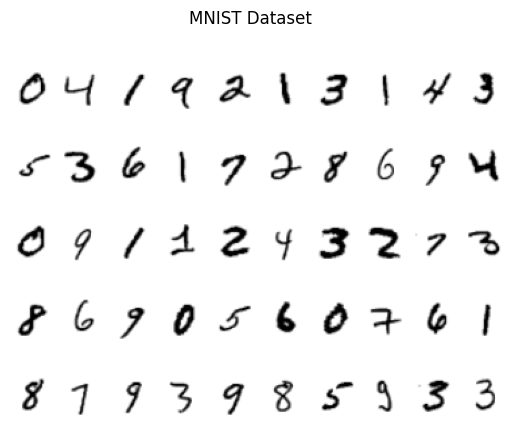

In [12]:
# transforms 정의하기
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# 데이터셋 다운로드 및 생성

full_dataset = datasets.MNIST(root="mnist_data", train=True, transform=transform, download=True)
full_dataset = ConcatDataset([full_dataset, datasets.MNIST(root="mnist_data", train=False, transform=transform)])

total_size = len(full_dataset)

train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 불러온 MNIST 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis("off")
    plt.imshow(train_dataset.dataset[index][0].squeeze(), cmap="gray_r")

fig.suptitle("MNIST Dataset")

# 데이터셋 크기 출력
print("train dataset size: ", len(train_dataset))
print("valid dataset size: ", len(valid_dataset))
print("test dataset size: ", len(test_dataset))

22:53:36 --- Start Training Loop ---


22:53:58 ---  Epoch: 1	Train loss: 0.5058	Valid loss: 0.2248	Train accuracy: 93.32	Valid accuracy: 93.02


22:54:22 ---  Epoch: 2	Train loss: 0.1742	Valid loss: 0.1395	Train accuracy: 96.07	Valid accuracy: 95.92


22:54:45 ---  Epoch: 3	Train loss: 0.1123	Valid loss: 0.1021	Train accuracy: 97.24	Valid accuracy: 96.76


22:55:08 ---  Epoch: 4	Train loss: 0.0823	Valid loss: 0.0907	Train accuracy: 97.76	Valid accuracy: 97.32


22:55:31 ---  Epoch: 5	Train loss: 0.0677	Valid loss: 0.0688	Train accuracy: 98.42	Valid accuracy: 97.97


22:55:54 ---  Epoch: 6	Train loss: 0.0554	Valid loss: 0.0625	Train accuracy: 98.71	Valid accuracy: 98.05


22:56:17 ---  Epoch: 7	Train loss: 0.0485	Valid loss: 0.0601	Train accuracy: 98.91	Valid accuracy: 98.16


22:56:39 ---  Epoch: 8	Train loss: 0.0419	Valid loss: 0.0520	Train accuracy: 99.13	Valid accuracy: 98.47


22:57:01 ---  Epoch: 9	Train loss: 0.0366	Valid loss: 0.0580	Train accuracy: 99.01	Valid accuracy: 98.22


22:57:24 ---  Epoch: 10	Train loss: 0.0310	Valid loss: 0.0504	Train accuracy: 99.27	Valid accuracy: 98.52


22:57:47 ---  Epoch: 11	Train loss: 0.0281	Valid loss: 0.0544	Train accuracy: 99.23	Valid accuracy: 98.44


22:58:10 ---  Epoch: 12	Train loss: 0.0238	Valid loss: 0.0612	Train accuracy: 99.23	Valid accuracy: 98.34


22:58:33 ---  Epoch: 13	Train loss: 0.0212	Valid loss: 0.0508	Train accuracy: 99.49	Valid accuracy: 98.64


22:58:56 ---  Epoch: 14	Train loss: 0.0182	Valid loss: 0.0557	Train accuracy: 99.49	Valid accuracy: 98.46


22:59:18 ---  Epoch: 15	Train loss: 0.0167	Valid loss: 0.0535	Train accuracy: 99.48	Valid accuracy: 98.62


22:59:40 ---  Epoch: 16	Train loss: 0.0162	Valid loss: 0.0546	Train accuracy: 99.65	Valid accuracy: 98.72


23:00:03 ---  Epoch: 17	Train loss: 0.0140	Valid loss: 0.0495	Train accuracy: 99.74	Valid accuracy: 98.78


23:00:26 ---  Epoch: 18	Train loss: 0.0125	Valid loss: 0.0558	Train accuracy: 99.67	Valid accuracy: 98.63


23:00:49 ---  Epoch: 19	Train loss: 0.0106	Valid loss: 0.0584	Train accuracy: 99.62	Valid accuracy: 98.65


23:01:12 ---  Epoch: 20	Train loss: 0.0097	Valid loss: 0.0538	Train accuracy: 99.85	Valid accuracy: 98.83


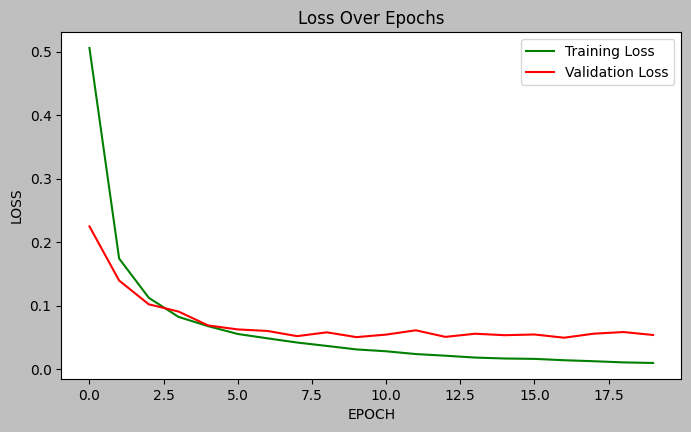

In [13]:
torch.manual_seed(RANDOM_SEED)

_model = LeNet5(NUM_CLASSES).cuda()
model = nn.DataParallel(_model).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_schedule(0))
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)

Test Loss: 0.0520, Test Accuracy: 0.9876


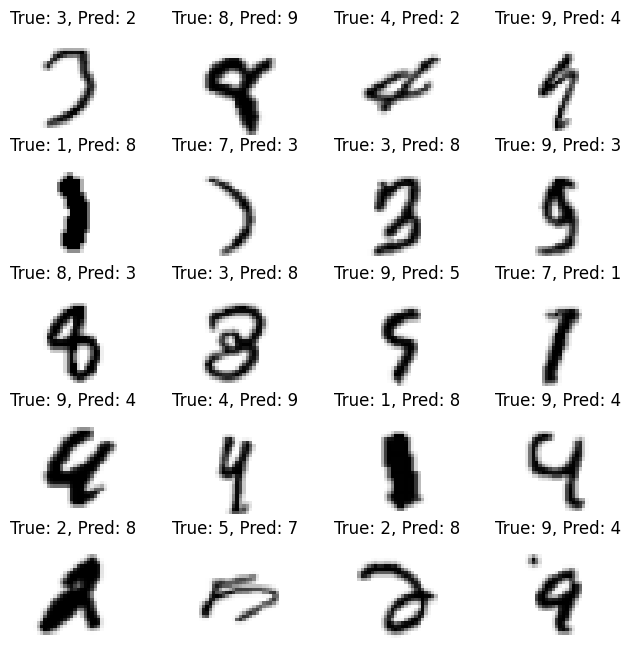

In [14]:
import matplotlib.pyplot as plt

# 테스트 데이터셋을 사용하여 모델의 성능을 평가하고 틀린 예시를 저장
def test_and_collect_mistakes(test_loader, model, criterion, device):
    model.eval()  # 평가 모드로 전환
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    mistakes = []

    with torch.no_grad():  # 평가시에는 그래디언트 계산 불필요
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 순전파와 손실 기록하기
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)

            # 예측 및 정확도 계산
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 틀린 예시 저장
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    mistakes.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))

    epoch_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / total

    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return epoch_loss, accuracy, all_preds, all_labels, mistakes

# 모델 학습이 완료된 후 평가 수행
test_loss, test_accuracy, test_preds, test_labels, mistakes = test_and_collect_mistakes(test_loader, model, criterion, DEVICE)

# 틀린 예시 시각화
def plot_mistakes(mistakes, num_examples=20):
    plt.figure(figsize=(8, 8))
    for i, (image, true_label, pred_label) in enumerate(mistakes[:num_examples]):
        plt.subplot(5, 4, i + 1)
        plt.axis('off')
        plt.imshow(image.squeeze(), cmap='gray_r')
        plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.show()

# 틀린 예시 출력
plot_mistakes(mistakes)
